In [1]:
import SegAN as segan
import tensorflow as tf
import numpy as np
import skimage.io as scio
from ipywidgets import interact, fixed, IntSlider, FloatSlider
import seaborn as sb

In [2]:
def predict_from_validation(run_name, checkpoint, mri_shape, seg_shape):
    '''
    :param input_mri: NDArray of shape [batch_size, H, W, channels]
    '''
    import dataset_helpers as dh
    import pandas as pd
    validation_dataset = dh.load_dataset('brats2015-Test-2013-only_positives',
                                        batch_size=32,
                                        prefetch_buffer=1,
                                        shuffle_buffer=32,
                                        shuffle=False,
                                        cache=True,
                                        mri_type="MR_T1",
                                        clip_labels_to=1.0,
                                        infinite = False)
    
    # Initialize network
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    net = segan.SegAN(mri_shape, seg_shape, config=config, run_name=run_name)
    
    result_list = list()
    
    # Creating the iterator
    tf.reset_default_graph()
    iterator = validation_dataset.make_one_shot_iterator()
    next_batch = iterator.get_next()

    with tf.Session(config=config) as sess:
        # Load (build) the network from the checkpoint
        net.build_network(next_batch['mri'], next_batch['seg'], session=sess, load_checkpoint=checkpoint)
        # Running evaluations on the entire dataset
        while True:
            try:
                results = sess.run({'prediction': net.layers['S']['out'], 'input': net.layers['in']['mri'], 'ground_truth': net.layers['in']['seg']}, feed_dict={net.layers['in']['training']: False})  
                result_list.append(results)
            except tf.errors.OutOfRangeError:
                break
    return result_list
    
    
    
def evaluate_all_checkpoints(run_name, mri_shape, seg_shape):
    import dataset_helpers as dh
    import pandas as pd
    validation_dataset = dh.load_dataset('brats2015-Test-2013-only_positives',
                                        batch_size=32,
                                        prefetch_buffer=1,
                                        shuffle_buffer=32,
                                        shuffle=False,
                                        cache=True,
                                        mri_type="MR_T1",
                                        clip_labels_to=1.0,
                                        infinite = False)
    
    # Initialize network
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    net = segan.SegAN(mri_shape, seg_shape, config=config, run_name=run_name)
    
    all_checkpoints = tf.train.get_checkpoint_state('../models/SegAN/loss_fixed_26_feb_model/').all_model_checkpoint_paths
    result_list = list()
    for checkpoint in all_checkpoints:
        # Creating the iterator
        tf.reset_default_graph()
        iterator = validation_dataset.make_one_shot_iterator()
        next_batch = iterator.get_next()
        
        with tf.Session(config=config) as sess:
            # Load (build) the network from the checkpoint
            net.build_network(next_batch['mri'], next_batch['seg'], session=sess, load_checkpoint=checkpoint)
            # Running evaluations on the entire dataset
            while True:
                try:
                    results = sess.run(net.layers['eval'], feed_dict={net.layers['in']['training']: False})
                    results['checkpoint'] = checkpoint
                    result_list.append(results)
                except tf.errors.OutOfRangeError:
                    break
                    
    # Make a DataFrame with all the results
    pd_eval = pd.DataFrame(result_list)
    # Save to CSV
    pd_eval.to_csv('eval_{}.csv'.format(run_name))

In [3]:
# Generate stats for every batch and save them in a csv file (takes about an hour)
#evaluations = evaluate_all_checkpoints('loss_fixed_26_feb', mri_shape=[32, 240, 240, 1], seg_shape=[32, 240, 240, 1])

In [4]:
import pandas as pd
ev = pd.read_csv('eval_loss_fixed_26_feb.csv', index_col = 0)
ev["batch_n"] =ev.groupby("checkpoint").cumcount() # Create a column for the batch enumeration
ev = ev.set_index(["checkpoint", "batch_n"]) # Set the new indices
ev

balanced_accuracy  \
checkpoint                                         batch_n                      
../models/SegAN/loss_fixed_26_feb_model/model.c... 0                 0.803846   
                                                   1                 0.785344   
                                                   2                 0.830285   
                                                   3                 0.813174   
                                                   4                 0.755996   
                                                   5                 0.851297   
                                                   6                 0.850785   
                                                   7                 0.807064   
                                                   8                 0.779544   
                                                   9                 0.680305   
                                                   10                0.731460   
                                                   11                0.806910   
                                                   12                0.836486   
                                                   13                0.826302   
                                                   14                0.639688   
                                                   15                0.656373   
                                                   16                0.761573   
                                                   17                0.807542   
                                                   18                0.833487   
                                                   19                0.793189   
                                                   20                0.695174   
                                                   21                0.841828   
                                                   22                0.929799   
                                                   23                0.819131   
                                                   24                0.826620   
                                                   25                0.821474   
                                                   26                0.872795   
                                                   27                0.924354   
                                                   28                0.824623   
                                                   29                0.847554   
...                                                                       ...   
../models/SegAN/loss_fixed_26_feb_model/model.c... 28                0.831646   
                                                   29                0.840083   
                                                   30                0.861108   
                                                   31                0.817786   
                                                   32                0.746692   
                                                   33                0.748710   
                                                   34                0.815076   
                                                   35                0.833253   
                                                   36                0.830946   
                                                   37                0.768805   
                                                   38                0.675548   
                                                   39                0.641095   
                                                   40                0.616979   
                                                   41                0.640066   
                                                   42                0.644013   
                                                   43                0.672769   
                                                   44                0.787765   
          

In [5]:
# Check which metrics make sense to consider by cheching the global stability
ev.var()
# 26 feb run showed that the metrics with most variance were sensitivity (2%), dice_score (1.3%), precision (1.2%). Balanced accuracy was at (0.5%) and others were mostly stable.

balanced_accuracy      0.005819
dice_score             0.013641
false_positive_rate    0.000025
precision              0.012517
sensitivity            0.023749
specificity            0.000025
dtype: float64

In [6]:
# 
evstats = ev.groupby(level="checkpoint").agg(['mean', 'var'])
top_models = list()
for m in ["dice_score", "sensitivity", "precision", "balanced_accuracy"]:
    top = evstats[m].nlargest(1, "mean")
    print("Best {} model: {}".format(m, top.index[0]))
    top_models.append(top.index[0])
evstats.loc[top_models,:]

Best dice_score model: ../models/SegAN/loss_fixed_26_feb_model/model.ckpt-1537500
Best sensitivity model: ../models/SegAN/loss_fixed_26_feb_model/model.ckpt-1599500
Best precision model: ../models/SegAN/loss_fixed_26_feb_model/model.ckpt-1547500
Best balanced_accuracy model: ../models/SegAN/loss_fixed_26_feb_model/model.ckpt-1599500


balanced_accuracy  \
                                                                mean   
checkpoint                                                             
../models/SegAN/loss_fixed_26_feb_model/model.c...          0.801257   
../models/SegAN/loss_fixed_26_feb_model/model.c...          0.822690   
../models/SegAN/loss_fixed_26_feb_model/model.c...          0.761880   
../models/SegAN/loss_fixed_26_feb_model/model.c...          0.822690   

                                                             dice_score  \
                                                         var       mean   
checkpoint                                                                
../models/SegAN/loss_fixed_26_feb_model/model.c...  0.005055   0.648567   
../models/SegAN/loss_fixed_26_feb_model/model.c...  0.004687   0.648130   
../models/SegAN/loss_fixed_26_feb_model/model.c...  0.005356   0.609066   
../models/SegAN/loss_fixed_26_feb_model/model.c...  0.004687   0.648130   

                                                              \
                                                         var   
checkpoint                                                     
../models/SegAN/loss_fixed_26_feb_model/model.c...  0.010944   
../models/SegAN/loss_fixed_26_feb_model/model.c...  0.011383   
../models/SegAN/loss_fixed_26_feb_model/model.c...  0.014920   
../models/SegAN/loss_fixed_26_feb_model/model.c...  0.011383   

                                                   false_positive_rate  \
                                                                  mean   
checkpoint                                                               
../models/SegAN/loss_fixed_26_feb_model/model.c...            0.007448   
../models/SegAN/loss_fixed_26_feb_model/model.c...            0.010247   
../models/SegAN/loss_fixed_26_feb_model/model.c...            0.005211   
../models/SegAN/loss_fixed_26_feb_model/model.c...            0.010247   

                                                             precision  \
                                                         var      mean   
checkpoint                                                               
../models/SegAN/loss_fixed_26_feb_model/model.c...  0.000023  0.717386   
../models/SegAN/loss_fixed_26_feb_model/model.c...  0.000038  0.665726   
../models/SegAN/loss_fixed_26_feb_model/model.c...  0.000009  0.749209   
../models/SegAN/loss_fixed_26_feb_model/model.c...  0.000038  0.665726   

                                                             sensitivity  \
                                                         var        mean   
checkpoint                                                                 
../models/SegAN/loss_fixed_26_feb_model/model.c...  0.011062    0.609961   
../models/SegAN/loss_fixed_26_feb_model/model.c...  0.015671    0.655627   
../models/SegAN/loss_fixed_26_feb_model/model.c...  0.012088    0.528971   
../models/SegAN/loss_fixed_26_feb_model/model.c...  0.015671    0.655627   

                                                             specificity  \
                                                         var        mean   
checkpoint                                                                 
../models/SegAN/loss_fixed_26_feb_model/model.c...  0.020613    0.992552   
../models/SegAN/loss_fixed_26_feb_model/model.c...  0.019178    0.989753   
../models/SegAN/loss_fixed_26_feb_model/model.c...  0.021600    0.994789   
../models/SegAN/loss_fixed_26_feb_model/model.c...  0.019178    0.989753   

                                                              
                                                         var  
checkpoint                                                    
../models/SegAN/loss_fixed_26_feb_model/model.c...  0.000023  
../models/SegAN/loss_fixed_26_feb_model/model.c...  0.000038  
../models/SegAN/loss_fixed_26_feb_model/model.c...  0.000009  
../models/SegAN/loss_fixed_26_feb_model/model.c...  0.000038

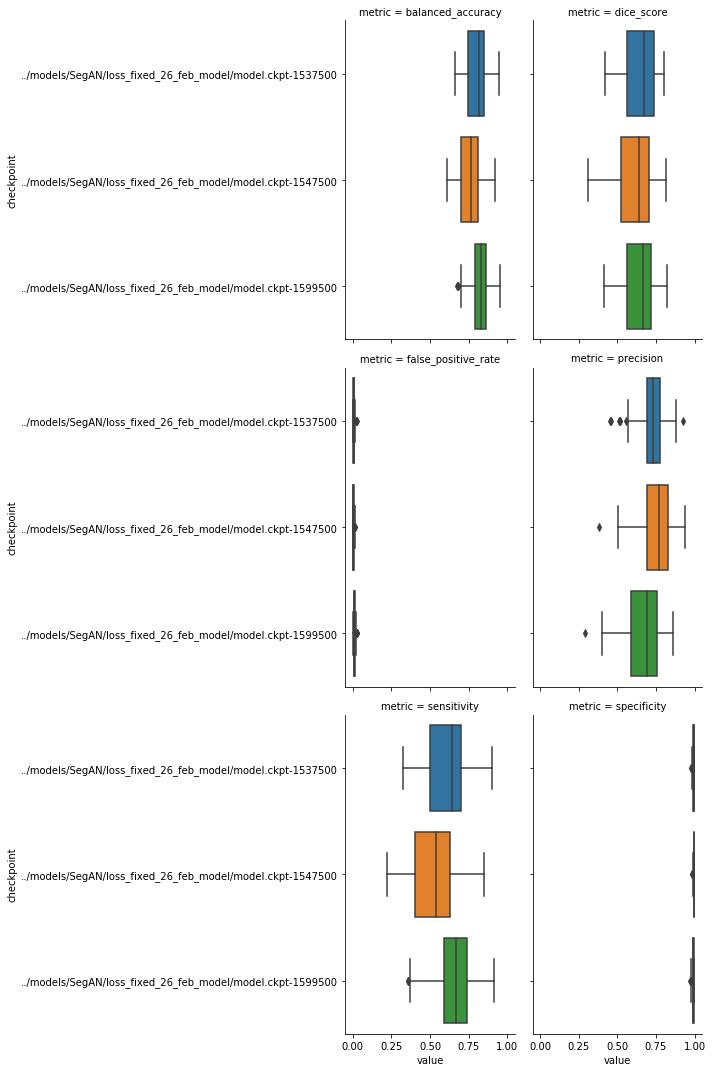

In [7]:
# Creating a version for plotting (Not actually feasible for too many checkpoints)
evp = ev.loc[top_models,:].stack().reset_index().rename(columns={'level_2':'metric', 0:'value'})
sb.catplot(x="value", y="checkpoint", col="metric", col_wrap=2, kind="box", data=evp, orient="h")

In [8]:
# Generate some predictions from validation set
model = "../models/SegAN/loss_fixed_26_feb_model/model.ckpt-1599500"
results = predict_from_validation(run_name='loss_fixed_26_feb', checkpoint=model, mri_shape=[32, 240, 240, 1], seg_shape=[32, 240, 240, 1])

INFO:tensorflow:Restoring parameters from ../models/SegAN/loss_fixed_26_feb_model/model.ckpt-1599500
Loaded model from ../models/SegAN/loss_fixed_26_feb_model/ at global step 1599500


In [9]:
import matplotlib.pyplot as plt
def visualize_results(results, batch_n, sample_n, gt_alpha, pred_alpha):
    input_sample = results[batch_n]['input'][sample_n, :,:,0]
    prediction = results[batch_n]['prediction'][sample_n, :,:,0]
    ground_truth = results[batch_n]['ground_truth'][sample_n, :,:,0]
    
    blank_channel = np.zeros([input_sample.shape[0], input_sample.shape[1]])
    
    # Make prediction and ground truth RGBA
    prediction = np.expand_dims(prediction, axis=-1)
    # Create a greyscale image with alpha channel
    prediction = prediction.repeat(4, axis=-1)
    # Make the prediction red
    prediction[:,:,1] = blank_channel
    prediction[:,:,2] = blank_channel
    # Same for the ground truth
    ground_truth = np.expand_dims(ground_truth, axis=-1)
    ground_truth = ground_truth.repeat(4, axis=-1)
    ground_truth[:,:,0] = blank_channel
    ground_truth[:,:,2] = blank_channel
    
    plt.figure(figsize=(8, 6), dpi=120)
    plt.imshow(input_sample, cmap="binary_r")
    plt.imshow(ground_truth, alpha=gt_alpha, cmap="Reds_r")
    plt.imshow(prediction, alpha=pred_alpha, cmap="Greens")
    


interact(visualize_results, results=fixed(results), batch_n=IntSlider(min=0,max=len(results)-1,step=1,value=0), sample_n=IntSlider(min=0,max=31,step=1,value=0), gt_alpha=FloatSlider(min=0,max=1,step=0.1,value=0), pred_alpha=FloatSlider(min=0,max=1,step=0.1,value=0));

interactive(children=(IntSlider(value=0, description='batch_n', max=57), IntSlider(value=0, description='sampl…